In [1]:
!pip install gymnasium


Running decaying epsilon experiment...
Running fixed epsilon experiment...


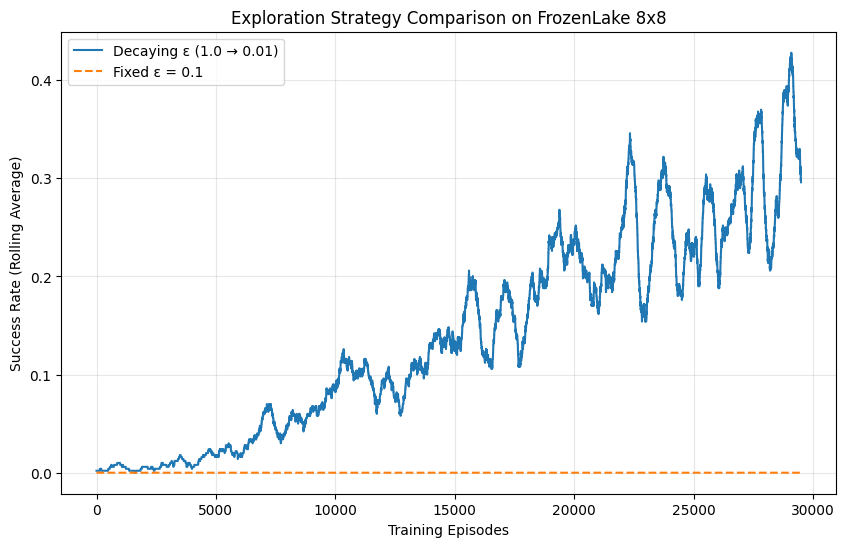

In [34]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Q-learning experiment
# -----------------------------
def run_experiment(
    epsilon_strategy="decay",
    fixed_epsilon=0.1,
    epsilon_decay=0.9999,
    num_episodes=30000
):
    # Environment
    env = gym.make(
        "FrozenLake-v1",
        map_name="8x8",
        is_slippery=True
    )

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Hyperparameters
    alpha = 0.1
    gamma = 0.99
    epsilon_min = 0.01
    epsilon = 1.0
    max_steps = 200

    # Q-table
    Q = np.zeros((n_states, n_actions))

    # Logging success
    episode_success = []

    # Training loop
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        success = 0

        for _ in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            td_target = reward if done else reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state

            if done:
                success = reward
                break

        # Epsilon update
        if epsilon_strategy == "decay":
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
        elif epsilon_strategy == "fixed":
            epsilon = fixed_epsilon

        episode_success.append(success)

    env.close()

    # Rolling success rate
    window = 500
    rolling_success = np.convolve(
        episode_success,
        np.ones(window) / window,
        mode="valid"
    )

    return rolling_success, Q  # Return both rolling success and Q-table

# -----------------------------
# Run experiments for both strategies
# -----------------------------
epsilon_strategies = ["decay", "fixed"]
results = {}
Q_epsilon = {}

print("Running decaying epsilon experiment...")
rolling_success, Q = run_experiment(epsilon_strategy="decay", epsilon_decay=0.9999)
results["decay"] = rolling_success
Q_epsilon["decay"] = Q

print("Running fixed epsilon experiment...")
rolling_success, Q = run_experiment(epsilon_strategy="fixed", fixed_epsilon=0.1)
results["fixed"] = rolling_success
Q_epsilon["fixed"] = Q

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(results["decay"], label="Decaying ε (1.0 → 0.01)")
plt.plot(results["fixed"], label="Fixed ε = 0.1", linestyle="--")
plt.title("Exploration Strategy Comparison on FrozenLake 8x8")
plt.xlabel("Training Episodes")
plt.ylabel("Success Rate (Rolling Average)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Analysis for epsilon strategy = decay
Policy Grid:
↓ ↓ → ↑ → ↓ ↓ ↓
↑ ↑ ↓ ↑ ↑ → → →
→ ← ← ← → ↑ ↓ →
↑ ↑ ← ↑ ← ← → ↓
← ↑ ← ← → ↓ ↑ →
← ← ← ↑ ↑ ← ← →
← ← → ← ← ← ← →
← ↑ ↓ ← ↑ ↓ ↓ ←


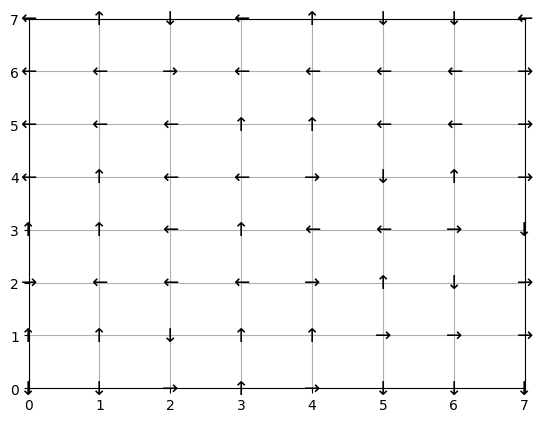

Empirical success probability: 0.368

Analysis for epsilon strategy = fixed
Policy Grid:
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←
← ← ← ← ← ← ← ←


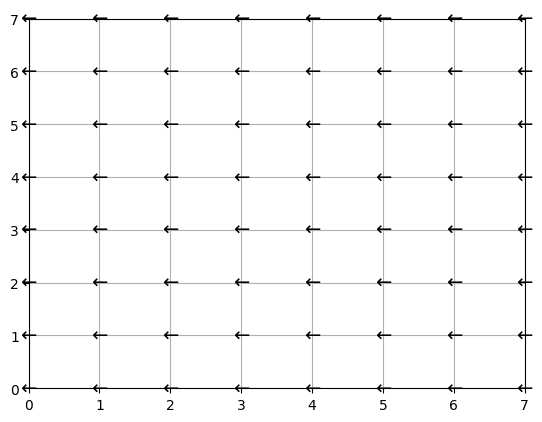

Empirical success probability: 0.000


In [35]:
# -----------------------------
# Post-training analysis for exploration strategies
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Extract greedy policy
def extract_greedy_policy(Q):
    return np.argmax(Q, axis=1)

# Visualize policy grid
def visualize_policy(policy, grid_size=8):
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy_grid = np.array([action_symbols[a] for a in policy]).reshape(grid_size, grid_size)

    print("Policy Grid:")
    for row in policy_grid:
        print(' '.join(row))

    # Optional matplotlib plot
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.grid(True)
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=14)
    plt.show()

# Evaluate policy over 1000 episodes
def evaluate_policy(policy, env_name="FrozenLake-v1", map_name="8x8", num_episodes=1000):
    env = gym.make(env_name, map_name=map_name, is_slippery=True)
    success_count = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        if reward == 1.0:
            success_count += 1
    return success_count / num_episodes

# -----------------------------
# Run analysis for each epsilon strategy
# -----------------------------
for strategy, Q in Q_epsilon.items():
    print(f"\nAnalysis for epsilon strategy = {strategy}")
    policy = extract_greedy_policy(Q)
    visualize_policy(policy, grid_size=8)
    success_prob = evaluate_policy(policy)
    print(f"Empirical success probability: {success_prob:.3f}")


In [40]:
print(
    "With decaying ε, the agent explores more in the beginning and gradually shifts to exploiting the learned Q-values. "
    "This leads to a steady increase in the success rate over training episodes.\n\n"
    "In contrast, the agent using a fixed ε = 0.1 does not learn effectively. Continuous random actions prevent it from "
    "consistently following the correct path, which is especially problematic in a large, stochastic environment like "
    "FrozenLake 8x8. As a result, its success rate remains close to zero."
)


With decaying ε, the agent explores more in the beginning and gradually shifts to exploiting the learned Q-values. This leads to a steady increase in the success rate over training episodes.

In contrast, the agent using a fixed ε = 0.1 does not learn effectively. Continuous random actions prevent it from consistently following the correct path, which is especially problematic in a large, stochastic environment like FrozenLake 8x8. As a result, its success rate remains close to zero.


Running experiment for alpha = 0.05
Running experiment for alpha = 0.3
Running experiment for alpha = 0.5
Running experiment for alpha = 0.7
Running experiment for alpha = 0.9


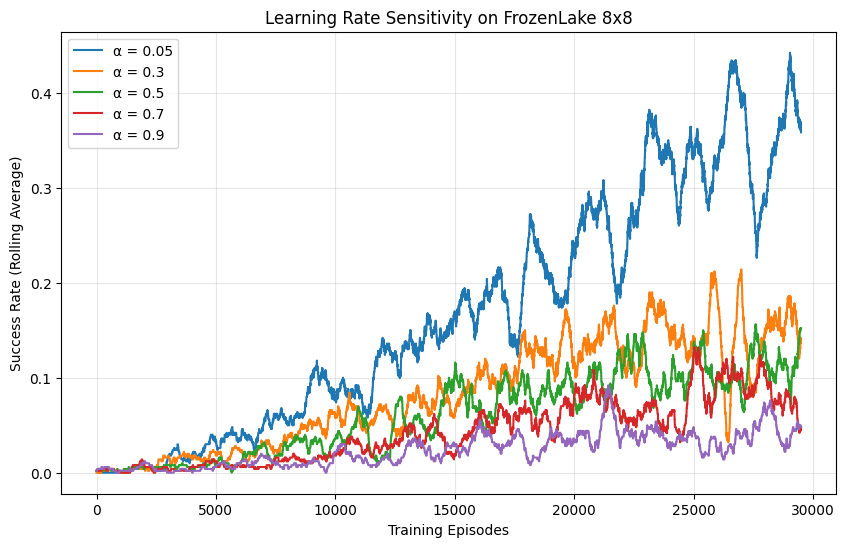

In [38]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Q-learning training function for alpha experiment
# -----------------------------
def run_alpha_experiment(alpha, num_episodes=30000):
    env = gym.make(
        "FrozenLake-v1",
        map_name="8x8",
        is_slippery=True
    )

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.9999
    epsilon_min = 0.01
    max_steps = 200

    Q = np.zeros((n_states, n_actions))
    episode_success = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        success = 0

        for _ in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            td_target = reward if done else reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state

            if done:
                success = reward
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_success.append(success)

    env.close()

    # Rolling success for plotting
    window = 500
    rolling_success = np.convolve(
        episode_success,
        np.ones(window) / window,
        mode="valid"
    )

    return rolling_success, Q  # Return both rolling success and Q-table

# -----------------------------
# Run experiments for different α
# -----------------------------
alphas = [0.05, 0.3, 0.5, 0.7, 0.9]
results = {}
Q_alpha = {}  # Dictionary to store Q-tables

for a in alphas:
    print(f"Running experiment for alpha = {a}")
    rolling_success, Q = run_alpha_experiment(alpha=a)
    results[a] = rolling_success
    Q_alpha[a] = Q  # Save Q-table

# -----------------------------
# Plot rolling success
# -----------------------------
plt.figure(figsize=(10, 6))
for a, success in results.items():
    plt.plot(success, label=f"α = {a}")
plt.title("Learning Rate Sensitivity on FrozenLake 8x8")
plt.xlabel("Training Episodes")
plt.ylabel("Success Rate (Rolling Average)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Analysis for alpha = 0.05
Policy Grid:
↓ → ↑ → ↓ ↓ → ↓
↑ ↑ ↑ ↑ ↓ → → →
↑ ↑ ← ← → ↑ → ↓
← ↑ ↑ ↑ ← ← → →
↑ ↑ ↑ ← → ↓ ↑ →
↑ ← ← ↑ ↑ ← ← →
→ ← → ← ← ← ← →
← ↓ ↑ ← ↓ ↑ → ←


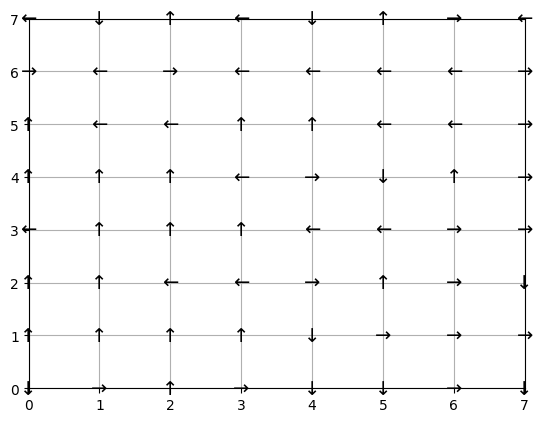

Empirical success probability: 0.495

Analysis for alpha = 0.3
Policy Grid:
← → ↓ ↓ ← ← → ↓
↑ ↑ ↑ ↑ ↑ ↓ → ←
↑ ↑ ← ← → ↑ → ←
↑ ↑ ← ↑ ← ← → ←
↑ ↑ ← ← → ↓ ↑ ↓
← ← ← → ↑ ← ← →
← ← → ↑ ← → ← →
← ↓ ← ← ↑ → ↓ ←


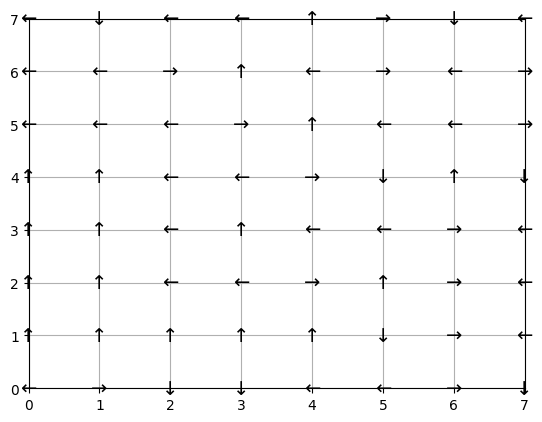

Empirical success probability: 0.165

Analysis for alpha = 0.5
Policy Grid:
↑ ← ↓ ↑ ↓ ↑ → ↓
↑ ↓ ↑ ↑ ↑ → ↓ →
↑ ← ← ← → → → →
↑ ← ↑ ↑ ← ← → ↓
→ ↑ ↑ ← → → ↑ →
← ← ← → ↑ ← ← →
← ← ↓ ← ← ← ← →
← ↓ ↓ ← ↓ ↓ ↓ ←


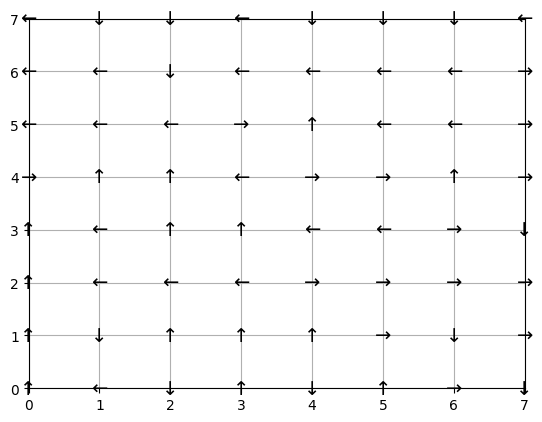

Empirical success probability: 0.159

Analysis for alpha = 0.7
Policy Grid:
↑ → ↓ ↓ ↓ → ↓ ↓
↓ ← ← ↑ ↓ → ↑ →
↑ → ← ← → ↑ ← ↑
← ← ← ← ← ← ↓ ↓
→ ↑ ← ← → ↓ ↓ →
↓ ← ← → ↑ ← ← →
→ ← ↑ ↑ ← → ← →
← ↓ → ← → → ↑ ←


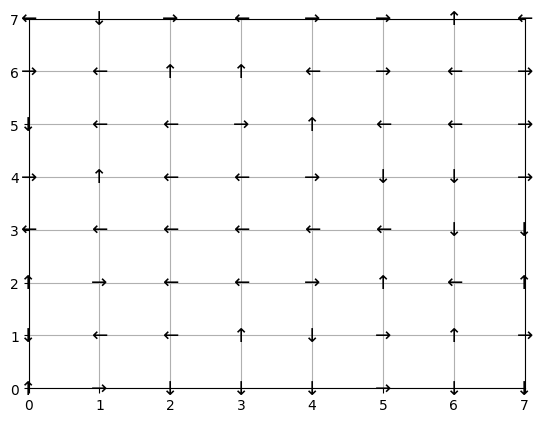

Empirical success probability: 0.040

Analysis for alpha = 0.9
Policy Grid:
↓ ↑ ↑ ↑ ← ↓ ← ↓
→ ← ← ↑ ↓ ↑ → →
← ← ← ← ← ← → ←
↑ ↓ ← ↓ ← ← → ↓
→ ↑ ↑ ← → ↓ → →
← ← ← ↓ ↑ ← ← →
↑ ← ↓ ← ← ← ← →
→ ↑ ← ← ← → ↓ ←


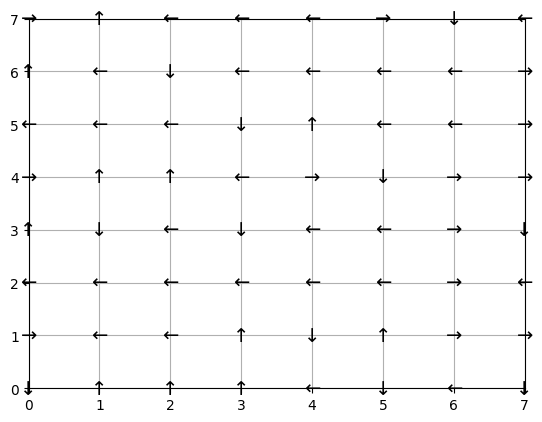

Empirical success probability: 0.059


In [39]:
# -----------------------------
# Post-training analysis for learning rate experiments
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Extract greedy policy
def extract_greedy_policy(Q):
    return np.argmax(Q, axis=1)

# Visualize policy grid
def visualize_policy(policy, grid_size=8):
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy_grid = np.array([action_symbols[a] for a in policy]).reshape(grid_size, grid_size)

    print("Policy Grid:")
    for row in policy_grid:
        print(' '.join(row))

    # Optional matplotlib plot
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.grid(True)
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=14)
    plt.show()

# Evaluate policy over 1000 episodes
def evaluate_policy(policy, env_name="FrozenLake-v1", map_name="8x8", num_episodes=1000):
    env = gym.make(env_name, map_name=map_name, is_slippery=True)
    success_count = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        if reward == 1.0:
            success_count += 1
    return success_count / num_episodes

# -----------------------------
# Run analysis for each alpha
# -----------------------------
for a, Q in Q_alpha.items():
    print(f"\nAnalysis for alpha = {a}")
    policy = extract_greedy_policy(Q)
    visualize_policy(policy, grid_size=8)
    success_prob = evaluate_policy(policy)
    print(f"Empirical success probability: {success_prob:.3f}")


In [17]:
print("""
The results demonstrate a clear relationship between the learning rate and the agent’s ability
to converge to a successful policy, with lower learning rates producing significantly better outcomes.
In particular, α = 0.05 yielded the highest final performance, achieving a success rate exceeding 40%.
Although learning progressed more slowly during the early stages of training, performance improved steadily
over time, and the corresponding learning curve was smooth, indicating stable convergence.

The configuration with α = 0.1 also performed well, reaching a peak success rate of approximately 30–35%.
This setting exhibited faster initial learning compared to α = 0.05, but its trajectory was noticeably
more volatile and ultimately converged to a lower success rate. As the learning rate increased beyond 0.1,
performance deteriorated substantially. With α = 0.3, the agent’s success rate plateaued around 20%,
suggesting limited learning capability. For higher values of α (0.5, 0.7, and 0.9), the agent failed
to learn an effective policy altogether, with success rates remaining below 15% throughout training.
These runs were characterized by highly erratic learning curves, indicating unstable updates and a lack of convergence.

This behavior highlights the trade-off between convergence speed and stability, particularly in stochastic environments.
While high learning rates can accelerate learning in deterministic settings, they are detrimental in FrozenLake
due to its probabilistic transition dynamics. A large learning rate causes the agent to heavily overweight recent experiences.
Consequently, stochastic events such as slipping into a hole can lead to disproportionately large negative updates,
causing the agent to overwrite previously accurate value estimates. This results in oscillatory learning and prevents the policy from stabilizing.

In contrast, lower learning rates enforce gradual updates to the Q-values, effectively averaging over the randomness inherent
in the environment. This smoothing effect allows the agent to recover from occasional adverse transitions and converge
toward the true expected value of each state–action pair. As a result, learning becomes more stable and reliable over
long training horizons.
""")



The results demonstrate a clear relationship between the learning rate and the agent’s ability 
to converge to a successful policy, with lower learning rates producing significantly better outcomes. 
In particular, α = 0.05 yielded the highest final performance, achieving a success rate exceeding 40%. 
Although learning progressed more slowly during the early stages of training, performance improved steadily 
over time, and the corresponding learning curve was smooth, indicating stable convergence. 

The configuration with α = 0.1 also performed well, reaching a peak success rate of approximately 30–35%. 
This setting exhibited faster initial learning compared to α = 0.05, but its trajectory was noticeably 
more volatile and ultimately converged to a lower success rate. As the learning rate increased beyond 0.1, 
performance deteriorated substantially. With α = 0.3, the agent’s success rate plateaued around 20%, 
suggesting limited learning capability. For higher values of α (0.5, 0.7

Running experiment for gamma = 0.9
Running experiment for gamma = 0.95
Running experiment for gamma = 0.99


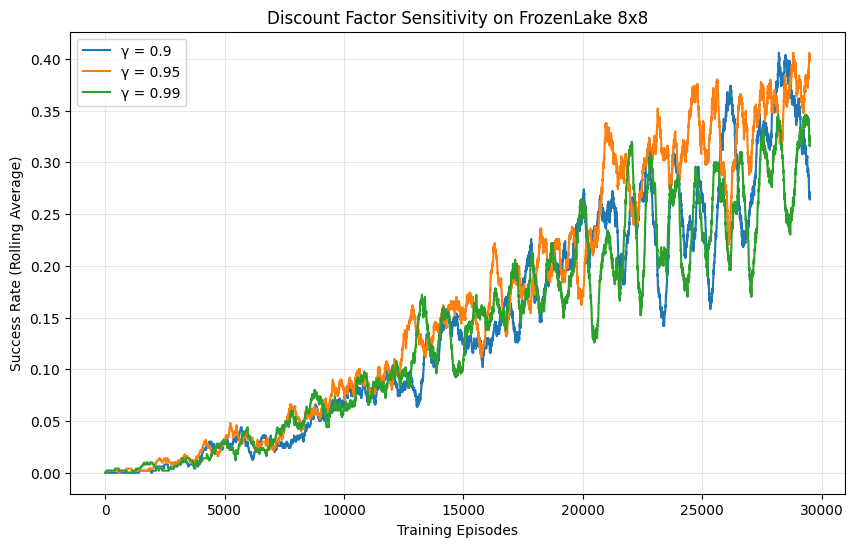

In [28]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Q-learning training function
# -----------------------------
def run_gamma_experiment(gamma, alpha=0.1, num_episodes=30000):
    env = gym.make(
        "FrozenLake-v1",
        map_name="8x8",
        is_slippery=True
    )

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    epsilon = 1.0
    epsilon_decay = 0.9999
    epsilon_min = 0.01
    max_steps = 200

    Q = np.zeros((n_states, n_actions))
    episode_success = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        success = 0

        for _ in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            td_target = reward if done else reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state

            if done:
                success = reward
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_success.append(success)

    env.close()

    # Rolling success for plotting
    window = 500
    rolling_success = np.convolve(
        episode_success,
        np.ones(window) / window,
        mode="valid"
    )

    return rolling_success, Q  # Return both rolling success and Q-table

# -----------------------------
# Run experiments for different γ
# -----------------------------
gammas = [0.90, 0.95, 0.99]
results_gamma = {}
Q_gamma = {}  # Dictionary to store Q-tables

for g in gammas:
    print(f"Running experiment for gamma = {g}")
    rolling_success, Q = run_gamma_experiment(gamma=g)
    results_gamma[g] = rolling_success
    Q_gamma[g] = Q  # Save Q-table

# -----------------------------
# Plot rolling success
# -----------------------------
plt.figure(figsize=(10, 6))
for g, success in results_gamma.items():
    plt.plot(success, label=f"γ = {g}")
plt.title("Discount Factor Sensitivity on FrozenLake 8x8")
plt.xlabel("Training Episodes")
plt.ylabel("Success Rate (Rolling Average)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Analysis for gamma = 0.9
Policy Grid:
↓ → → → → → → ←
↑ ↑ ↑ ↑ → → ↓ →
→ → ← ← → ↑ ↓ ↓
↑ ↑ ↑ ↑ ← ← → ↓
↑ ↑ ↑ ← → ↓ ↓ →
↑ ← ← → ↑ ← ← →
← ← → ↑ ← ← ← →
← ↑ ← ← → → ↓ ←


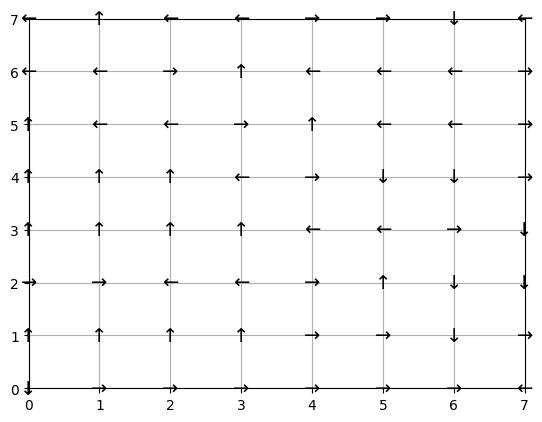

Empirical success probability: 0.375

Analysis for gamma = 0.95
Policy Grid:
→ → → → → → → ←
↑ ↑ ↑ ↑ → → → →
↑ ↑ ← ← → ↑ ↓ ↓
↑ ↑ ↑ ↓ ← ← → ←
↑ ↑ ← ← → ↓ ↑ →
← ← ← ↓ ↑ ← ← →
← ← → ← ← ← ← →
← ↑ ↑ ← ↓ → ↓ ←


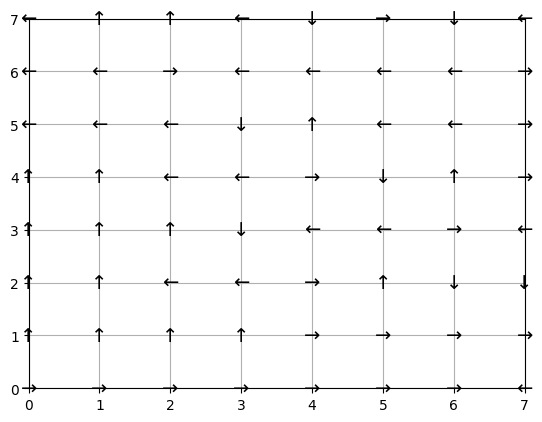

Empirical success probability: 0.444

Analysis for gamma = 0.99
Policy Grid:
↓ → → ↑ → → ↓ ↓
↑ → ↑ ↑ → ↑ ← ←
↑ ↑ ← ← → ↑ → ←
→ ↑ ← ↓ ← ← → ←
← ↑ ← ← → ↓ ↑ ↓
← ← ← → ↑ ← ← →
← ← → ← ← → ← →
← ↓ ← ← → → ↓ ←


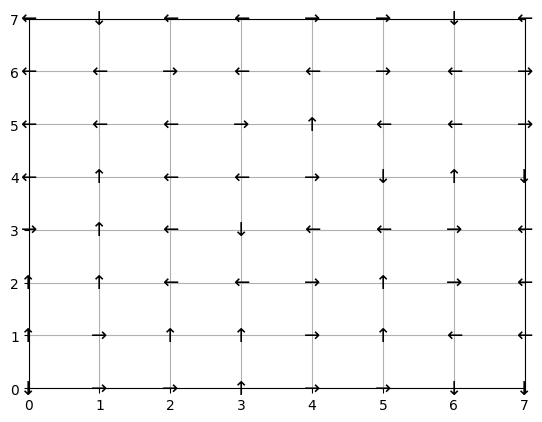

Empirical success probability: 0.256


In [29]:
# -----------------------------
# Post-training analysis for Q-tables
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Extract greedy policy
def extract_greedy_policy(Q):
    return np.argmax(Q, axis=1)

# Visualize policy grid
def visualize_policy(policy, grid_size=8):
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy_grid = np.array([action_symbols[a] for a in policy]).reshape(grid_size, grid_size)

    print("Policy Grid:")
    for row in policy_grid:
        print(' '.join(row))

    # Optional matplotlib plot
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.grid(True)
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=14)
    plt.show()

# Evaluate policy over 1000 episodes
def evaluate_policy(policy, env_name="FrozenLake-v1", map_name="8x8", num_episodes=1000):
    env = gym.make(env_name, map_name=map_name, is_slippery=True)
    success_count = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        if reward == 1.0:
            success_count += 1
    return success_count / num_episodes

# -----------------------------
# Run analysis for each gamma
# -----------------------------
# If you didn't save Q-tables, you need to re-run training with return of Q included.
# For demonstration, assuming you have a dictionary `Q_gamma` with trained Q-tables

# Example: If your training code didn't return Q, you need to modify it to:
# rolling_success, Q = run_gamma_experiment(gamma=g)
# Q_gamma[g] = Q

# Here is the analysis assuming you have Q_gamma dictionary:
for g in gammas:
    print(f"\nAnalysis for gamma = {g}")
    Q = Q_gamma[g]  # Q-table for this gamma
    policy = extract_greedy_policy(Q)
    visualize_policy(policy, grid_size=8)
    success_prob = evaluate_policy(policy)
    print(f"Empirical success probability: {success_prob:.3f}")


In [19]:
print("""
3. Discount Factor (γ) Sensitivity Analysis

This experiment evaluated how the discount factor (γ) affects the agent’s ability to learn a safe policy
on the 8×8 FrozenLake environment. Three values were tested: γ = 0.90, γ = 0.95, and γ = 0.99.

The agent with γ = 0.95 achieved the highest success rate, consistently exceeding 40%, indicating an
optimal balance between valuing long-term rewards and maintaining stable learning. The γ = 0.90 agent
performed moderately, plateauing around 30%, while γ = 0.99 showed lower and unstable performance
(20–30%), likely due to slow reward propagation and oscillating policies.

These differences reflect risk-sensitive behavior near holes. A lower γ causes the agent to be myopic,
favoring shorter, riskier paths, whereas a very high γ encourages extreme caution but slows learning.
The γ = 0.95 agent effectively balances foresight and learning efficiency, avoiding holes while converging reliably.

In conclusion, γ = 0.95 is the optimal discount factor for this environment, providing sufficient foresight
without the convergence issues observed at γ = 0.99.
""")



3. Discount Factor (γ) Sensitivity Analysis

This experiment evaluated how the discount factor (γ) affects the agent’s ability to learn a safe policy 
on the 8×8 FrozenLake environment. Three values were tested: γ = 0.90, γ = 0.95, and γ = 0.99.

The agent with γ = 0.95 achieved the highest success rate, consistently exceeding 40%, indicating an 
optimal balance between valuing long-term rewards and maintaining stable learning. The γ = 0.90 agent 
performed moderately, plateauing around 30%, while γ = 0.99 showed lower and unstable performance 
(20–30%), likely due to slow reward propagation and oscillating policies.

These differences reflect risk-sensitive behavior near holes. A lower γ causes the agent to be myopic, 
favoring shorter, riskier paths, whereas a very high γ encourages extreme caution but slows learning. 
The γ = 0.95 agent effectively balances foresight and learning efficiency, avoiding holes while converging reliably.

In conclusion, γ = 0.95 is the optimal discount 